In [17]:
import os
import cv2
import numpy as np
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, Bidirectional, LSTM,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [27]:
DATASET_PATH = r"E:\harsh\mini_dataset"  # Change this if different
FRAME_SIZE = (128, 128)
NUM_FRAMES = 20
NUM_CLASSES = 9

In [19]:
# Helper function to load frames from a video
def load_video_frames(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    cap.release()

    # Pad with black frames if needed
    while len(frames) < num_frames:
        frames.append(np.zeros((frame_size[1], frame_size[0], 3)))

    return np.array(frames[:num_frames], dtype=np.float32)

# Label mapping
label_names = sorted(os.listdir(DATASET_PATH))
label_to_index = {label: idx for idx, label in enumerate(label_names)}

print("Label mapping:", label_to_index)

# Load all videos and labels
videos = []
labels = []

for label in label_names:
    label_folder = os.path.join(DATASET_PATH, label)
    for video_file in os.listdir(label_folder):
        if video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            video_path = os.path.join(label_folder, video_file)
            frames = load_video_frames(video_path)
            videos.append(frames)
            labels.append(label_to_index[label])

# Convert to numpy arrays
X_data = np.array(videos, dtype=np.float32)
Y_data = to_categorical(np.array(labels), num_classes=len(label_names))

print("X_data shape:", X_data.shape)
print("Y_data shape:", Y_data.shape)


Label mapping: {'bring water for me': 0, 'congratulations': 1, 'help me': 2, 'how old are you': 3, 'i am hungry': 4, 'i am tired': 5, 'i need water': 6, 'what do you do': 7, 'who are you': 8}
X_data shape: (376, 20, 128, 128, 3)
Y_data shape: (376, 9)


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [21]:
ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_data, Y_data, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 300
Validation samples: 76


In [28]:
def build_custom_model(input_shape, num_classes):
    video_input = Input(shape=input_shape)  # (20, 128, 128, 3)

    # CNN layers inside TimeDistributed
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(video_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)

    # BiLSTM for sequence modeling
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=video_input, outputs=output)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model


In [29]:
input_shape = (NUM_FRAMES, FRAME_SIZE[1], FRAME_SIZE[0], 3)  # (20, 128, 128, 3)
model = build_custom_model(input_shape, num_classes=NUM_CLASSES)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 20, 128, 128, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 128, 128, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 20, 64, 64, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 20, 32, 32, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 20, 32768)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │      33,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,813,833 (128.99 MB)

 Trainable params: 33,813,833 (128.99 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',       # You can also use 'val_accuracy'
    patience=10,              # Wait 10 epochs after no improvement
    restore_best_weights=True # Restore the best weights at the end
)


In [30]:
history= model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val), 
          epochs=300, 
          batch_size=4)

Epoch 1/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.1004 - loss: 2.3438 - val_accuracy: 0.1053 - val_loss: 2.1937
Epoch 2/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.1102 - loss: 2.2027 - val_accuracy: 0.1184 - val_loss: 2.2184
Epoch 3/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.1248 - loss: 2.2334 - val_accuracy: 0.1447 - val_loss: 2.2020
Epoch 4/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.1783 - loss: 2.1783 - val_accuracy: 0.1579 - val_loss: 2.1915
Epoch 5/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.1275 - loss: 2.1803 - val_accuracy: 0.2105 - val_loss: 2.0495
Epoch 6/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.3118 - loss: 1.8609 - val_accuracy: 0.4737 - val_loss: 1.4922
Epoch 7/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.6223 - loss: 1.1033 - val_accuracy: 0.6053 - val_loss: 1.0558
Epoch 8/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.7409 - loss: 0.7138 - val_accuracy: 0.

In [31]:
model.save('sign_language_mode_best_isl.h5')


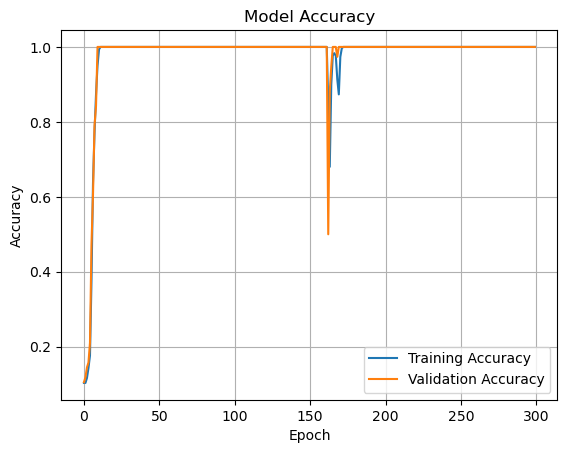

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_graph_isl.png")
plt.show()


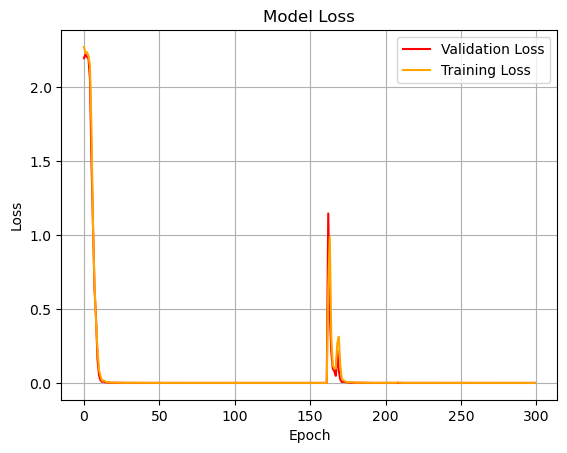

In [34]:
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_loss_graph_isl.png")
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


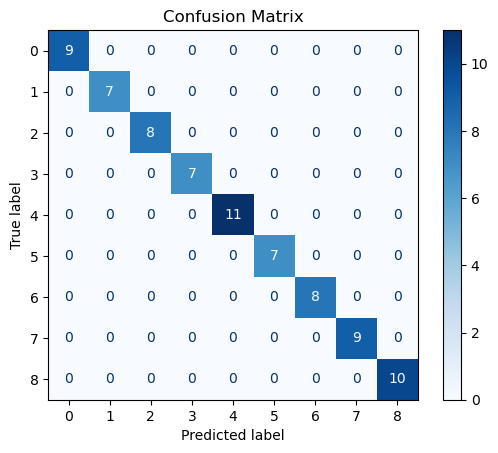

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
# Predict probabilities
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# If your true labels are one-hot encoded, convert them too
y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
labels = list(range(cm.shape[0]))  # or use class names if available

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("confussion_matrix.png")
plt.show()
